# Bolt Home Task — "1st Time Payments Analysis"
## Author: Bogdan Romanov

### Task
_About 40% of our transactions are cashless - meaning we are charging clients and paying majority of the charge to the driver every week (withholding our 15-25% commissions).
We always pay the driver and take the risk for collecting the funds from the client.
Luckily, we have basic filters to block users from making multiple fraudulent transactions and find groups of fraudulent users using the same devices or cards. Now the next step is to stop people who are doing fraudulent transaction for the first time._

_Based on the sample data please come up with the top 2-5 developments that should be done to reduce the percent of failed payments (state “is_successful_payment” as 0). Keeping in mind our developer team is small (3-4 people), describe why you picked exactly those.
If some parameters are missing from the list below, you can presume we collect all reasonable data that we possibly can, while using the platform as a rider or driver.
When describing the top developments, please write how did you come to that conclusion - we are not only interested in the outcome, but also the process and how you approach problems._

<br>

## Literature review and hypotheses

The overall task of the assignment is to capture the riders who most likely have malicious intentions (the following narrative and comments will be only on the rider side of service provision). Even a brief glimpse at the data allows us to deduce that there are records for EU and non-EU countries within the timeframe of 2015-2017. Thus, I propose the following developments, which are based on a non-exhaustive literature review and personal experience with the Bolt product (I did submit a home task for Data Analyst in the Billing team).

1. __EU/non-EU distinction__ — This might be the most important variable in the analysis since this latent factor contains GDP difference, quality and level of living standards, salaries variability, as well as devices being used (I reached this conclusion in my another home assignment). Hence, I will pay attention to this variable in the first place.
2. __Time-dependency__ — another non-directly connected variable with fraud would be time, especially since time-series data was provided — my initial assumption that the distribution of the `is_successful_payment` variable might be time-dependent (i.e., weekly seasonality, seasons and holidays). This will be the second direction of my report.
3. __Promo abuse__ — the situation in which the client tries to abuse the promo codes, obtained in some way. With the data on our hands, we can check the difference in `price` and `ride_price`. The former might be lower exactly because of the discounts/promo codes. However, there should be a threshold within the price differences and accompanying features. Maybe `is_successful_payment` will be intertwined with this feature. This will be the core contribution of the report because my initial logic unpacked something curious. Hence I will pinpoint the core explanatory indicator, which would,, in theory,, reduce the number of failed first-time payments.
4. __Price review reason__ — there are only 1108 entries with particular `price_review_reason`; since Bolt strives to be reactive and user-friendly, it is worth analyzing rider's feedback

Other mechanisms cannot be fully analyzed with the data provided, but it would be interesting to assess them later!
1. __Account Takeover (ATO)__ — this fraudulent workaround might be more complicated to observe with our data mostly because we need data on digital fingerprints on the devices, not on the rides themselves.
2. __Spoofed GPS location__ — similar to the _Jumper_ (2008) movie, our clients might be changing their location via GPS manipulations; this can be unveiled by checking the difference between `lat`-`lng` and `real_destination_lat`-`real_destination_lng.` However, it would be problematic to compare the distance and the difference in latitude and longitude -- but maybe the Fraud team could teach me how to do that!

The following task structure is straightforward; I will check the data for missing values or any other discrepancies. The second stage is feature engineering, manifested in the creation of several new variables which were missing initially. Finally, I will conduct a more detailed analysis of the abovementioned ideas. Comments from my side will accompany all these stages.

### Sources:
1. Bakhshi, Kosar, Behnam Bahrak, and Hamid Mahini. 2021. “Fraud Detection System in Online Ride-Hailing Services.” In 2021 7th International Conference on Signal Processing and Intelligent Systems (ICSPIS), 1–6. https://doi.org/10.1109/ICSPIS54653.2021.9729379.
2. “Device Spoofing: A Sign of Serious Mobile App Security Threats.” n.d. Accessed May 7, 2023. https://nethone.com/blog/device-spoofing-a-sign-of-serious-mobile-app-security-threats.
3. Gopani, Avi. 2022. “Behind Uber’s RADAR Fraud Detection System.” Analytics India Magazine. February 10, 2022. https://analyticsindiamag.com/behind-ubers-radar-fraud-detection-system/.
4. “How Fraudsters Take Advantage of Ride-Hailing Apps.” n.d. Accessed May 5, 2023. https://nethone.com/blog/how-fraudsters-take-advantage-of-ride-hailing-apps.
5. “How Fraudsters Take Ride-Hailing Apps for a Ride | SHIELD.” n.d. Accessed May 5, 2023. https://shield.com/blog/ride-hailing-fraud.
6. “InDrive Partners SHIELD to Bring Transparency and Fraud Detection for Its Ride-Hailing Platform.” 2023. Financialexpress (blog). January 25, 2023. https://www.financialexpress.com/express-mobility/indrive-partners-shield-to-bring-transparency-and-fraud-detection-for-its-ride-hailing-platform/2959489/.
7. “Project RADAR: Intelligent Early Fraud Detection System with Humans in the Loop.” 2022. Uber Blog. February 1, 2022. https://www.uber.com/en-IN/blog/project-radar-intelligent-early-fraud-detection/.
8. “Creating an anti-fraud system in a taxi from scratch.” 2020. Хабр. July 28, 2020. https://habr.com/ru/articles/512752/.


<br>

In [1]:
%%javascript
IPython.notebook.kernel.execute('''
import seaborn as sns
sns.set(rc={'figure.figsize':(25,9)})
''')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

sns.set(rc={'figure.figsize':(25,9)})

## Data preparation

In my mindset, the first step in any data-related task is to check the data and its adequacy. By that, I imply:
- Checking missing values;
- Dealing with the NAs in data;
- Assessing the match between the variable and data type

In [3]:
df_original = pd.read_csv('1st_adyen_rides-success-and-fail.csv', parse_dates=['created'])
df = df_original.copy()
print(df.shape)
df.head(10)

(304053, 22)


,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
0,2016-01-23 23:10:07,motorolaXT1562,motorola6.0.1,ee,2.0,58.378220,26.710402,58.363243,26.737696,218,...,773,3017,4.5000,4.5000,ok,NaN,1,**** 0810,NaN,0
1,2016-05-04 06:01:32,iPhone6,iOS10.3.3,ee,1.0,59.424130,24.646359,59.397548,24.660957,266,...,43,4241,4.4000,4.4000,ok,NaN,1,**** 9115,NaN,0
2,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,1654,6347,7.2000,7.2000,ok,NaN,1,**** 0634,516903.0,0
3,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,883,2638,3.1000,3.1000,ok,NaN,1,**** 8730,541747.0,0
4,2016-09-09 12:46:47,"iPhone5,2",iOS9.3.4,ee,1.0,59.471328,24.890557,59.427836,24.774460,944,...,1109,10288,9.0999,9.0999,ok,NaN,1,**** 3503,NaN,0
5,2016-04-07 05:09:06,samsungSM-A510F,samsung7.0,ee,1.0,59.427594,24.774963,59.395243,24.663802,1326,...,110,9621,8.4000,8.4000,ok,NaN,1,**** 8236,547372.0,1
6,2016-12-10 08:15:15,iPhone6S,iOS10.3.1,ee,1.0,59.427273,24.774457,59.404176,24.636704,1401,...,943,11415,8.1999,8.1999,ok,NaN,1,**** 2768,516737.0,0
7,2016-11-20 14:52:46,iPhone6,iOS10.3.1,ee,1.0,59.408856,24.723877,59.417374,24.797121,1426,...,1235,8340,8.1999,8.1999,ok,NaN,1,**** 5856,559078.0,0
8,2016-07-12 12:57:35,iPhone7Plus,iOS10.3.2,ee,1.0,59.383566,24.842994,59.428953,24.720008,1442,...,7544,14190,11.1000,11.1000,ok,NaN,1,**** 6427,NaN,0
9,2016-03-22 17:43:09,motorolaMoto G (5),motorola7.0,ee,1.0,59.421310,24.670074,59.421664,24.670887,1632,...,880,3290,3.8000,3.8000,ok,NaN,1,**** 2575,516737.0,0


In the beginning, we have a dataset with 22 variables and 304 053 observations from __September 2015 to August 2017__.

<br>

#### Missing values

In [4]:
print(df.isna().sum().sort_values(ascending=False).head(7))
df.isna().sum()/len(df)

price_review_reason     302945
card_bin                  6578
city_id                    319
real_destination_lat        27
real_destination_lng        27
country                      1
created                      0
dtype: int64


created                  0.000000
device_name              0.000000
device_os_version        0.000000
country                  0.000003
city_id                  0.001049
lat                      0.000000
lng                      0.000000
real_destination_lat     0.000089
real_destination_lng     0.000089
user_id                  0.000000
order_id                 0.000000
order_try_id             0.000000
distance                 0.000000
ride_distance            0.000000
price                    0.000000
ride_price               0.000000
price_review_status      0.000000
price_review_reason      0.996356
is_successful_payment    0.000000
name                     0.000000
card_bin                 0.021634
failed_attempts          0.000000
dtype: float64

Once we sort the missing values, we see that out of 304 053, `price_review_reason` misses 302 945 values, leaving us with 1108 present records. This means that in 99.6% of cases, there was no reason inserted for a price review, which means that either rider was satisfied with the price or did not react. Even the sample with 1108 observations is curious enough, and I will include it in the analysis as Hypothesis 5.

Apart from that, there are missing values for `card_bin` (2% of the whole dataset), `city_id` (less than 0.1%), and several others.

In this case, since the limited sample with `price_review_reason` will be studied separately and other variables have no more than 2% of missing data, I will just drop the rows with the missing values (firstly, I will drop `price_review_reasons`, and then I will clean the dataset — here I cannot drop `card_bin` variable since it has information on the banks and there could be a hypothesis that frequent failure in payment is associated with a particular bank).

In [5]:
df = df.drop('price_review_reason', axis=1)
df = df.dropna().reset_index(drop=True)
df.head()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,order_try_id,distance,ride_distance,price,ride_price,price_review_status,is_successful_payment,name,card_bin,failed_attempts
0,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,6792534,1654,6347,7.2000,7.2000,ok,1,**** 0634,516903.0,0
1,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,8103655,883,2638,3.1000,3.1000,ok,1,**** 8730,541747.0,0
2,2016-04-07 05:09:06,samsungSM-A510F,samsung7.0,ee,1.0,59.427594,24.774963,59.395243,24.663802,1326,...,4813318,110,9621,8.4000,8.4000,ok,1,**** 8236,547372.0,1
3,2016-12-10 08:15:15,iPhone6S,iOS10.3.1,ee,1.0,59.427273,24.774457,59.404176,24.636704,1401,...,9654561,943,11415,8.1999,8.1999,ok,1,**** 2768,516737.0,0
4,2016-11-20 14:52:46,iPhone6,iOS10.3.1,ee,1.0,59.408856,24.723877,59.417374,24.797121,1426,...,8943449,1235,8340,8.1999,8.1999,ok,1,**** 5856,559078.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297137 entries, 0 to 297136
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   created                297137 non-null  datetime64[ns]
 1   device_name            297137 non-null  object        
 2   device_os_version      297137 non-null  object        
 3   country                297137 non-null  object        
 4   city_id                297137 non-null  float64       
 5   lat                    297137 non-null  float64       
 6   lng                    297137 non-null  float64       
 7   real_destination_lat   297137 non-null  float64       
 8   real_destination_lng   297137 non-null  float64       
 9   user_id                297137 non-null  int64         
 10  order_id               297137 non-null  int64         
 11  order_try_id           297137 non-null  int64         
 12  distance               297137 non-null  int6

Since I parsed the `created` datetime object while uploading the dataset, all other variables have an appropriate data type. In theory, I could replace '****' for card number (`name`) to change it to `integer`, but this number does not carry any substantial meaning.

It is unlikely that I would check the strings for trailing spaces, but retrospectively I added this check as well for `price_review_reasons`.

In [7]:
list(df_original['price_review_reason'].unique())

[nan,
 'price_calculation_warnings ',
 'price_too_high             ',
 'calculation_failed         ']

In [8]:
df_original.price_review_reason = df_original.price_review_reason.str.strip()
list(df_original.price_review_reason.unique())

[nan, 'price_calculation_warnings', 'price_too_high', 'calculation_failed']

<br>

#### Feature Engineering

Before moving to the analysis, I would like to add a full country name and EU and non-EU binary flag. The former is introduced for convenience, while the latter is required for main Hypothesis 1.

In [9]:
country_names = {'ee': 'Estonia',
                'ua': 'Ukraine',
                'lv': 'Latvia',
                'hu': 'Hungary',
                'ge': 'Georgia',
                'lt': 'Lithuania',
                'mt': 'Malta',
                'pl': 'Poland',
                'za': 'South Africa',
                'fi': 'Finland',
                'sk': 'Slovakia',
                'cz': 'Czech Republic',
                'ro': 'Romania',
                'rs': 'Serbia',
                'ng': 'Nigeria',
                'ke': 'Kenya',
                'mx': 'Mexico',
                'az': 'Azerbaijan',
                'gh': 'Ghana',
                'eg': 'Egypt',
                'ca': 'Canada',
                'sa': 'Saudi Arabia',
                'nan': 'nan'
                }

country_name = df['country']

for key, values in country_names.items():
    country_name = country_name.replace(key, values)

df['country_name'] = country_name
df.head()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,is_successful_payment,name,card_bin,failed_attempts,country_name
0,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,1654,6347,7.2000,7.2000,ok,1,**** 0634,516903.0,0,Estonia
1,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,883,2638,3.1000,3.1000,ok,1,**** 8730,541747.0,0,Estonia
2,2016-04-07 05:09:06,samsungSM-A510F,samsung7.0,ee,1.0,59.427594,24.774963,59.395243,24.663802,1326,...,110,9621,8.4000,8.4000,ok,1,**** 8236,547372.0,1,Estonia
3,2016-12-10 08:15:15,iPhone6S,iOS10.3.1,ee,1.0,59.427273,24.774457,59.404176,24.636704,1401,...,943,11415,8.1999,8.1999,ok,1,**** 2768,516737.0,0,Estonia
4,2016-11-20 14:52:46,iPhone6,iOS10.3.1,ee,1.0,59.408856,24.723877,59.417374,24.797121,1426,...,1235,8340,8.1999,8.1999,ok,1,**** 5856,559078.0,0,Estonia


In [10]:
eu_list = ['ee', 'lv', 'hu', 'lt', 'mt', 'pl', 'fi', 'cz']

df['is_eu'] = [1 if i in eu_list else 0 for i in df.country]
df.head()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,ride_distance,price,ride_price,price_review_status,is_successful_payment,name,card_bin,failed_attempts,country_name,is_eu
0,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,6347,7.2000,7.2000,ok,1,**** 0634,516903.0,0,Estonia,1
1,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,2638,3.1000,3.1000,ok,1,**** 8730,541747.0,0,Estonia,1
2,2016-04-07 05:09:06,samsungSM-A510F,samsung7.0,ee,1.0,59.427594,24.774963,59.395243,24.663802,1326,...,9621,8.4000,8.4000,ok,1,**** 8236,547372.0,1,Estonia,1
3,2016-12-10 08:15:15,iPhone6S,iOS10.3.1,ee,1.0,59.427273,24.774457,59.404176,24.636704,1401,...,11415,8.1999,8.1999,ok,1,**** 2768,516737.0,0,Estonia,1
4,2016-11-20 14:52:46,iPhone6,iOS10.3.1,ee,1.0,59.408856,24.723877,59.417374,24.797121,1426,...,8340,8.1999,8.1999,ok,1,**** 5856,559078.0,0,Estonia,1


Now we have a full name of a country, fetched from the country code, and flag for all observations if the country where the ride was finished belongs to the EU or not.

<br>

#### Data Analysis

#### Hypothesis 1
_There is a difference in failed payments for EU and non-EU samples_

As I tried to hint in the introductory section, the EU and non-EU ride-hailing markets are extremely different: starting from micro-factors like mode of payments, distances, currencies and finishing with macro, i.e., economies, societal well-being, and crises, etc. This statement is supported by my academic experience and by my work with the upfront price prediction for the EU and non-EU markets for the Billing team.

In [11]:
table = pd.pivot_table(df, values='user_id',
                       columns = 'is_successful_payment',
                       index='is_eu',
                       aggfunc='count',
                       margins=True
                       )
table = table.rename(index={0:'non-EU', 1:'EU'})
table = table.rename(columns={0:'failed', 1:'successful'})
table.iloc[:-1]

is_successful_payment,failed,successful,All
is_eu,,,
non-EU,46788,94932,141720
EU,28915,126502,155417


In [12]:
table = pd.pivot_table(df,
                       values='user_id',
                       columns = 'is_successful_payment',
                       index='is_eu',
                       aggfunc='count',
                       margins=True
                       )
table = table.rename(index={0:'non-EU', 1:'EU'})
table = table.rename(columns={0:'failed', 1:'successful'})
table.div(table.iloc[:,-1], axis=0)

is_successful_payment,failed,successful,All
is_eu,,,
non-EU,0.330144,0.669856,1.0
EU,0.186048,0.813952,1.0
All,0.254775,0.745225,1.0


Despite the fact that the number of observations for EU and non-EU is almost equal (141 thousand for non-EU and 155 thousand for EU), it seems that non-EU countries do experience failed payments more frequently: 33% of the first payments in non-EU samples failed in comparison to 19% in EU sample.

Let me verify our observation with statistics.

In [13]:
sample1 = df[df['is_eu'] == 1]['is_successful_payment']
sample2 = df[df['is_eu'] == 0]['is_successful_payment']

count = [sum(sample1), sum(sample2)]
nobs = [len(sample1), len(sample2)]

zstat, pvalue = proportions_ztest(count, nobs)

print(f'z-stat: {zstat:.2f}, p-value: {pvalue:.4f}')

z-stat: 90.04, p-value: 0.0000


Since our dependent variable/label was binary (`is_successful_payment`), I used a two-proportion z-test under the assumption that our EU and non-EU samples are independent. Since the p-value is extremely low, we may conclude that the difference between the samples is statistically significant and worth exploring.

In [14]:
df['is_successful_payment_str'] = df['is_successful_payment'].astype('string',copy=False)
df.head()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,price,ride_price,price_review_status,is_successful_payment,name,card_bin,failed_attempts,country_name,is_eu,is_successful_payment_str
0,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,7.2000,7.2000,ok,1,**** 0634,516903.0,0,Estonia,1,1
1,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,3.1000,3.1000,ok,1,**** 8730,541747.0,0,Estonia,1,1
2,2016-04-07 05:09:06,samsungSM-A510F,samsung7.0,ee,1.0,59.427594,24.774963,59.395243,24.663802,1326,...,8.4000,8.4000,ok,1,**** 8236,547372.0,1,Estonia,1,1
3,2016-12-10 08:15:15,iPhone6S,iOS10.3.1,ee,1.0,59.427273,24.774457,59.404176,24.636704,1401,...,8.1999,8.1999,ok,1,**** 2768,516737.0,0,Estonia,1,1
4,2016-11-20 14:52:46,iPhone6,iOS10.3.1,ee,1.0,59.408856,24.723877,59.417374,24.797121,1426,...,8.1999,8.1999,ok,1,**** 5856,559078.0,0,Estonia,1,1


Now let me take one step further and move from the supranational/regional level to the country level via visualizations.

[Text(0.5, 0, 'Country name'),
 Text(0, 0.5, 'Count of payment'),
 Text(0.5, 1.0, 'EU region')]

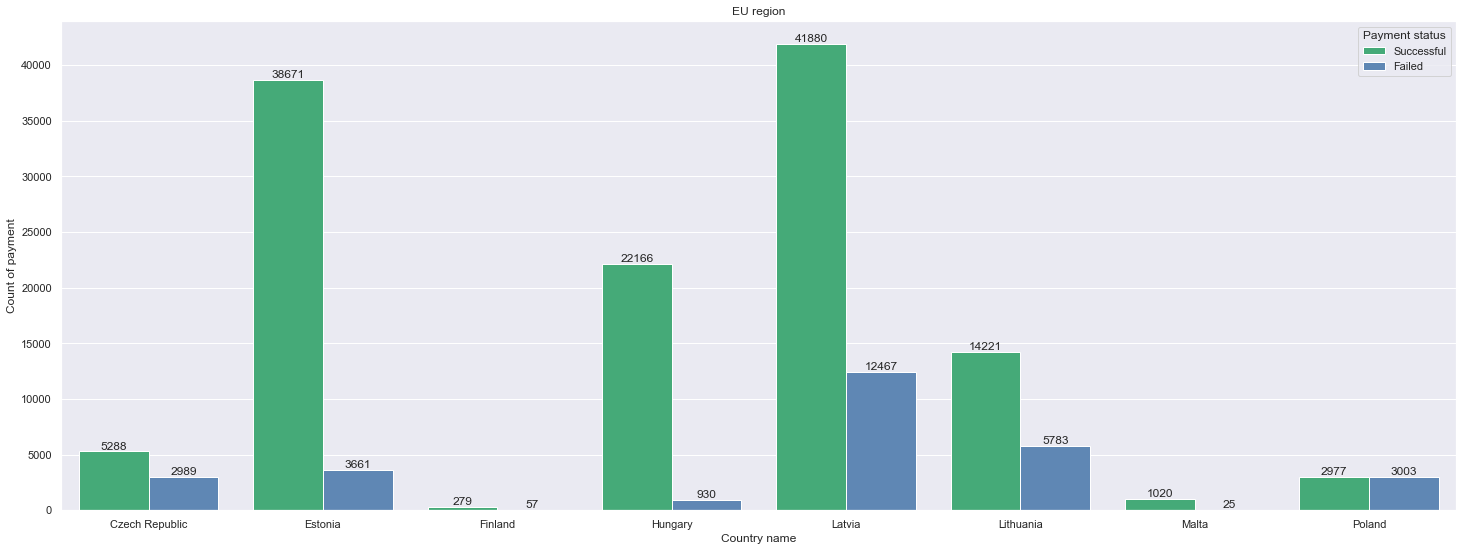

In [15]:
d = sns.countplot(data=df[(df['is_eu'] == 1)].sort_values(by='country_name'),
                  x='country_name',
                  hue='is_successful_payment_str',
                  palette=['#34BB78', '#5186C2'],
                  )
d.legend(title='Payment status',
         labels=['Successful', 'Failed']
         )
d.bar_label(d.containers[0])
d.bar_label(d.containers[1])
d.set(xlabel='Country name',
      ylabel='Count of payment',
      title='EU region'
      )

Following the logic of EU vs. non-EU, the split for the EU sample is somewhat expected: a lot of orders, the majority of which are successful, as follows from the pivot table. Poland might be an interesting case since the number of successes and failures is almost equal there — this is interesting, but in a negative connotation, it should be explored in more detail by our team. Also, the Czech Republic and Lithuania should be investigated because the ratio is not appealing.

On the other hand, Estonia, Hungary, and Latvia are setting an example of effective and efficient systems and maybe fewer fraudulent clients, assuming that the payment failed due to suspicious activity.

If I were applying to the Campaigns team, I would say that Finland and Malta do require more service penetration due to the low number of finished orders, at least with the timeframe of 2015-2017.

[Text(0.5, 0, 'Country name'),
 Text(0, 0.5, 'Count of payment'),
 Text(0.5, 1.0, 'non-EU region')]

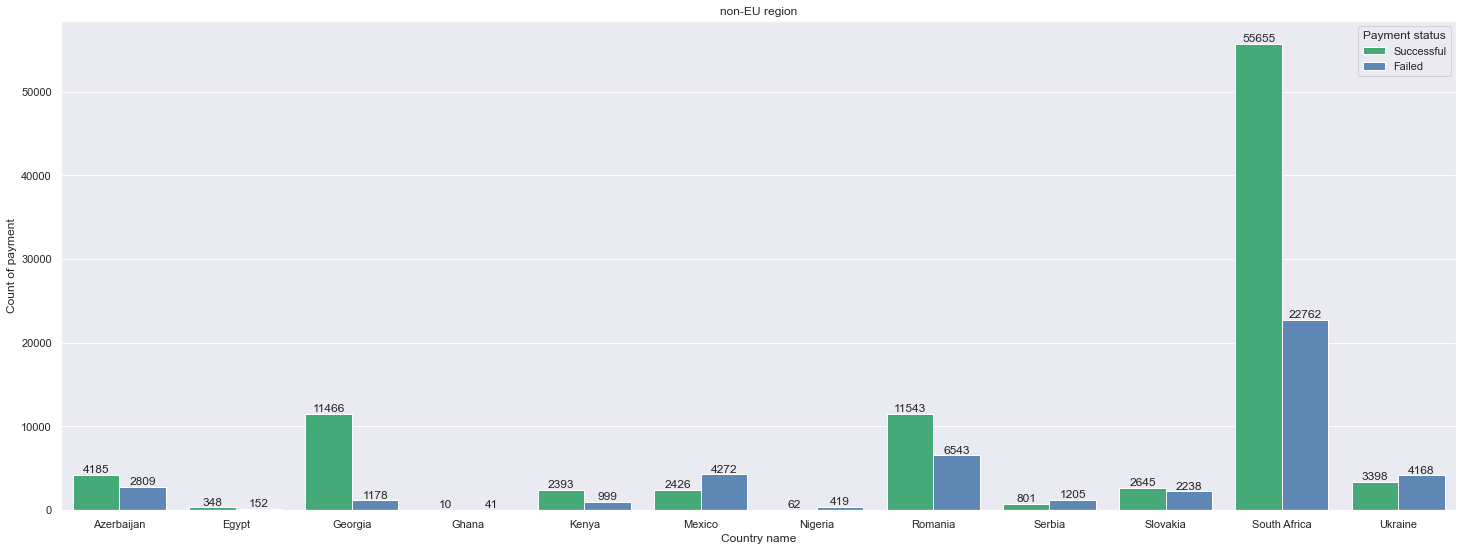

In [16]:
g = sns.countplot(data=df[(df['is_eu'] == 0) & (~df['country_name'].isin(['Canada', 'Saudi Arabia']))].sort_values(by=['country_name', 'is_successful_payment']),
                  x='country_name',
                  hue='is_successful_payment_str',
                  hue_order = ['1', '0'],
                  palette=['#34BB78', '#5186C2'],
                  )
g.legend(title='Payment status',
         labels=['Successful', 'Failed']
         )
g.bar_label(g.containers[0])
g.bar_label(g.containers[1])
g.set(xlabel='Country name',
           ylabel='Count of payment',
           title='non-EU region'
           )

First of all, I filtered out Canada and Saudi Arabia, where each had one finished ride. The most drastic difference to the EU sample is that the non-EU sample lacks homogeneity; South Africa has the biggest number of successful and failed orders (I might assume that the number is bigger than the sum of other non-EU countries).

For Mexico, Ukraine, Serbia, and Ghana, the number of failed payments overrides the number of successes.

Summarizing, the first large-scale development is that the non-EU market might be more problematic due to the less developed banking system and prevalence of cash payments. Thus, fraud systems should be more sensitive here in the non-EU region, especially in South Africa, due to the high number of orders, 1/3 of which failed for the first payment. Romania also has a relatively high number of orders, but more than every second payment fails. I do insist that EU/non-EU distinction is crucial for the analysis, so I will carry it throughout the entirety of the report.

Also, I would like to introduce an easily-maintainable tool for assessing the success rate of payments, the map with color coding and per-city information.

In [17]:
df_map = df[['country', 'country_name', 'city_id', 'lat', 'lng', 'is_successful_payment']]
map_data = df_map.groupby(['country_name', 'city_id'])[['is_successful_payment', 'lat', 'lng']].mean()

In [18]:
map = folium.Map([41.3745795, 12.7223798], zoom_start=3, control_scale=True, zoom_control=True, scrollWheelZoom=False)
for row in map_data.itertuples():
    if row.is_successful_payment < 0.25:
        color = '#da1e28'
        fill_color = color
    elif (row.is_successful_payment >= 0.25) & (row.is_successful_payment < 0.5):
        color = '#ff832b'
        fill_color = color
    elif (row.is_successful_payment >= 0.5) & (row.is_successful_payment < 0.75):
        color = '#f1c21b'
        fill_color = color
    else:
        color= '#198038'
        fill_color = 'color'


    folium.CircleMarker((row.lat, row.lng),
                        radius=5,
                        color=color,
                        fill=True,
                        tooltip=f'Success rate in {row[0][0]} is: {round(row.is_successful_payment, 2)}',
                        size=1).add_to(map)
map

The map above might be one of the tools how to control the fraud level on a global scale, where Bolt ride-hailing services are present. The zoom functionality is available through the buttons in the top left corner, and the hover-over markers provide information on the country name and success rate in the city (since city names are ids, there was not much sense in adding them to the navigation). The color coding should be intuitive, `red` implies a low level of success rate for the first-time payment or a low number of finished rides, while `green` — a success rate above 75%.

Technically, I can easily set it up, so the map can be updated with a couple of clicks and inserted in the internal report. The markers could be replaced with choropleth codification once the city names are shared (although some are guessable from the map).

<br>

#### Hypothesis 2
_The distribution of failed payments varies across time_

My assumption is due to the time-dependent demand for Bolt ride-hailing (see the image below), the failures in payments are either associated with the distribution or have a unique pattern. The sample is different, but commonalities are observed: people do use Bolt services once the business day is over.

<img src="photo_2023-05-12_08-29-50.jpg" alt="Bolt_taxi_demand_for_one_day"/>

The first stage here is to select such part of the dataset, which would capture the overall pattern of data distribution. I decided to go with the year 2016 since the data for 2015 presented only from September and for 2017 —  until August. In other words, only 2016 covers the whole year.

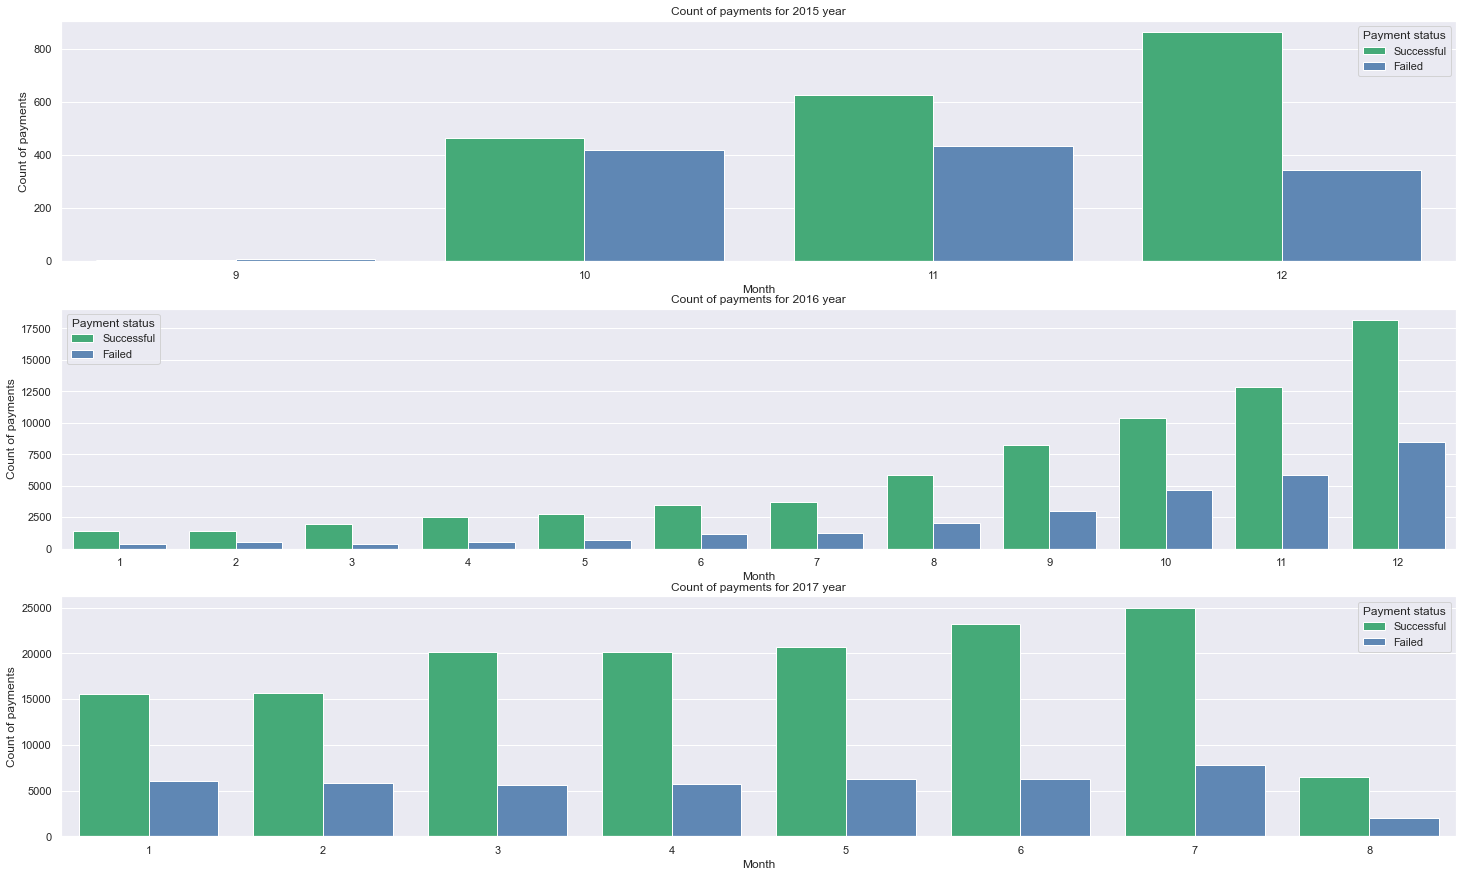

In [19]:
year_list = [2015, 2016, 2017]

fig, axs = plt.subplots(nrows=3, figsize=(25, 15))


for i, year in enumerate(year_list):
    g=sns.countplot(data=df[df.created.dt.year == year],
                    x=df[df.created.dt.year == year].created.dt.month,
                    hue='is_successful_payment_str',
                    ax = axs[i],
                    palette=['#34BB78', '#5186C2']
                    )
    g.legend(title='Payment status',
             labels=['Successful', 'Failed']
             )
    g.set(xlabel='Month',
          ylabel='Count of payments',
          )
    axs[i].set(title=f'Count of payments for {year} year')


How wrong I was with my initial assumption...
The data itself has a unique distribution, where for the year 2016, the number of orders resembles cumulative aggregation (until year 2017, see lineplot below), but it is not the case. So I do not dare to continue elaborating on this hypothesis and label it falsified, at least with this approach.

In [20]:
df.groupby(pd.Grouper(key='created', freq='1M'))['order_id'].count()

created
2015-09-30        9
2015-10-31      881
2015-11-30     1063
2015-12-31     1206
2016-01-31     1731
2016-02-29     1945
2016-03-31     2300
2016-04-30     3042
2016-05-31     3420
2016-06-30     4580
2016-07-31     4924
2016-08-31     7869
2016-09-30    11232
2016-10-31    15021
2016-11-30    18709
2016-12-31    26664
2017-01-31    21660
2017-02-28    21560
2017-03-31    25774
2017-04-30    25880
2017-05-31    26946
2017-06-30    29455
2017-07-31    32762
2017-08-31     8504
Freq: M, Name: order_id, dtype: int64

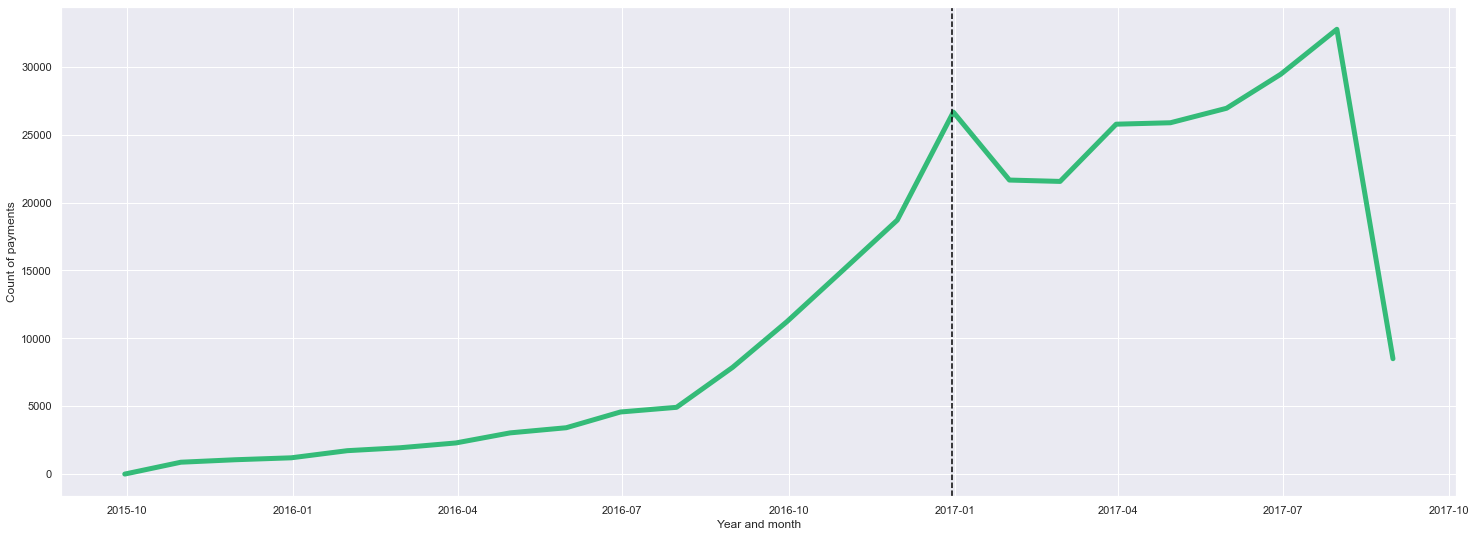

In [21]:
g = sns.lineplot(data = df.groupby(pd.Grouper(key='created', freq='1M'))['order_id'].count(),
                 color='#34BB78',
                 linewidth=5
                 ).set(xlabel='Year and month',
                                      ylabel='Count of payments'
                                      )
plt.axvline(17165,
            color='black',
            linestyle='dashed'
            )

However, not everything is so dire if we assume that all years homogeneous and do not have differences in distribution. In theory, we can analyze the entire dataset as one year because 2017 data ended in September and 2015 data started in September; thus, it artificially creates one year. Let's see what we will get with this approach.

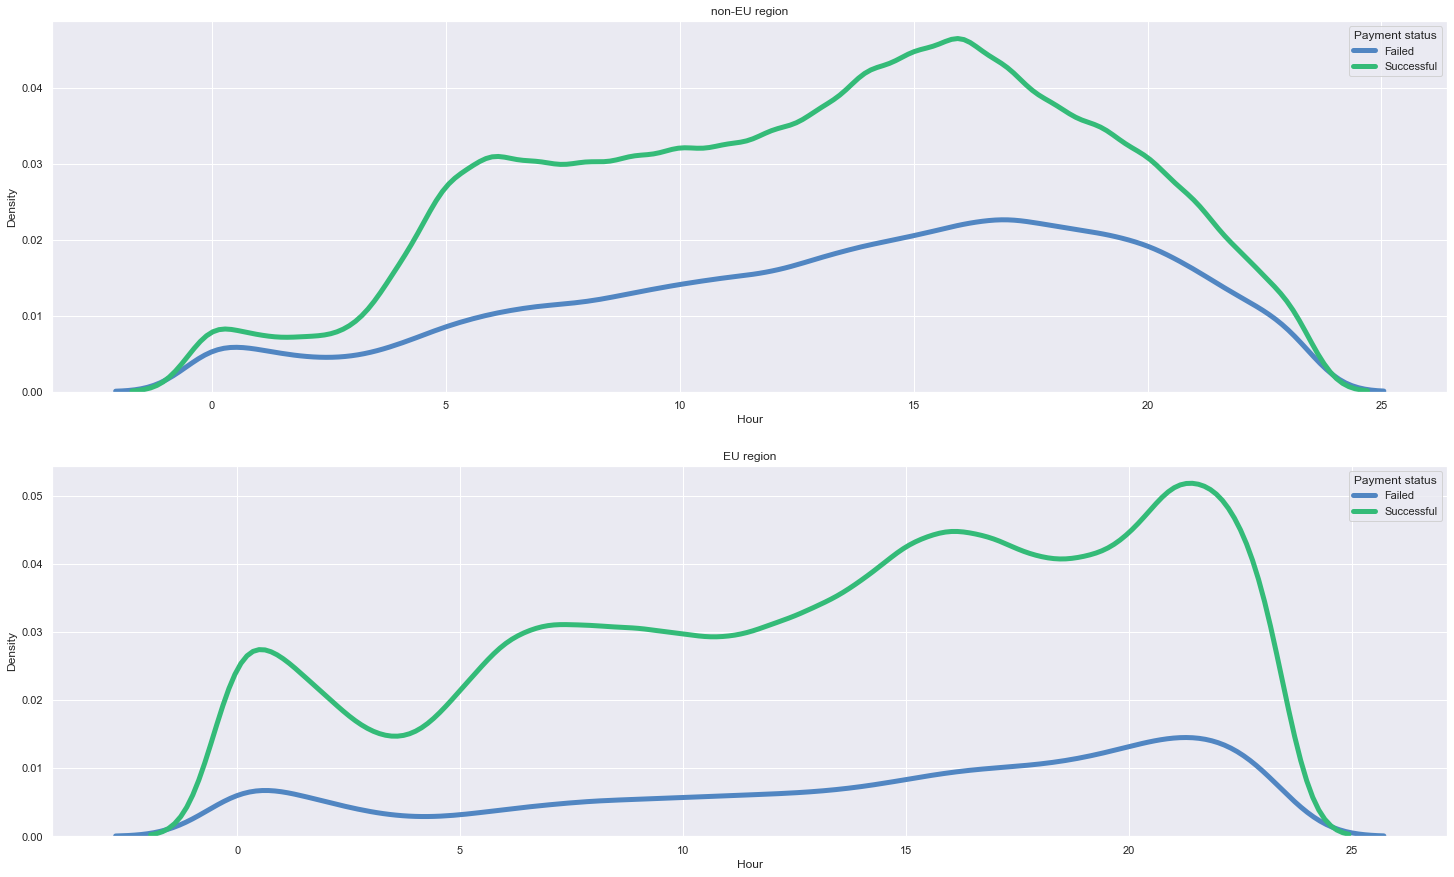

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(25, 15))
eu_non_list = [0, 1]

for i, region in enumerate(eu_non_list):
    g = sns.kdeplot(data=df[df.is_eu==region],
                    x=df[df.is_eu==region].created.dt.hour,
                    hue='is_successful_payment_str',
                    hue_order = ['1', '0'],
                    palette=['#34BB78', '#5186C2'],
                    linewidth=5,
                    ax=axs[i]
                    )
    g.legend(title='Payment status',
             labels=['Failed', 'Successful']
             )
    if region == 0:
        g.set(xlabel='Hour',
              title='non-EU region'
              )
    else:
        g.set(xlabel='Hour',
              title='EU region'
              )

With such a design, we can visually assess the distribution for aggregated values for two years and claim that in the EU number of failed payments spiked at night (after 8 PM and until 4 AM), while non-EU regions steadily increases throughout the day with higher pace than in the EU and spikes at 5 PM with a lag from the highest value in uptake.

This observation might be helpful to the Fraud unit since it limits the timeframe when intensive monitoring should be deployed, thus, saving resources.

I should note that Hypothesis 2 is made under the assumption that the time is converted to the UTC or to another baseline.

<br>

#### Hypothesis 3
Promo abuses and failed payments

The idea here stems from public sources, and I will try to check if somehow the rider was able to abuse the system and decreases the ride's price in some way. For that, I calculated the new variable `discount`, which is a ratio of price differences to the price charged to the client.

In [23]:
df['discount'] = (df['ride_price'] - df['price'])/df['ride_price']
print(df.shape)
print(df.discount.value_counts().head(10))
# sum(list(df.discount.value_counts().head(10)[1:]))
print(df.is_successful_payment_str.value_counts())

(297137, 25)
0.000000    201645
1.000000     56080
0.909091      1156
0.833333       952
0.952381       877
0.769231       862
0.714286       785
0.869565       750
0.666667       732
0.800000       653
Name: discount, dtype: int64
1    221434
0     75703
Name: is_successful_payment_str, dtype: Int64


Let me remind the reader that we have 297 137 observations after removing missing values, and out of that number, 201 645 users paid full `ride_price,` while about 63 thousand riders had discounts larger than 50% and 56 thousand riders had a final price of 0 currency units (I hope those are not Bolt employees exploiting their credits). This fact raises two moments: I am jealous because I always get 25% discount maximum! Secondly, jokes aside, this might be the main factor explaining the failed payments. Let me double-check that!

In [24]:
display(df[df.discount.isna() == True].head())
df[df.discount.isna() == True]['is_successful_payment_str'].value_counts()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,ride_price,price_review_status,is_successful_payment,name,card_bin,failed_attempts,country_name,is_eu,is_successful_payment_str,discount
10,2017-06-14 13:00:25,OnePlusONEPLUS A3003,OnePlus7.1.1,ee,1.0,59.420321,24.697136,59.330578,24.472601,2853,...,0.0,ok,0,**** 2822,516867.0,0,Estonia,1,0,NaN
25,2016-03-03 15:11:32,OnePlusONE E1003,OnePlus6.0.1,ee,1.0,59.416350,24.692010,59.406597,24.658743,5031,...,0.0,ok,0,**** 8997,529412.0,0,Estonia,1,0,NaN
30,2016-01-22 07:02:45,iPhone7,iOS10.1,ee,1.0,59.412517,24.648007,59.399812,24.669028,5820,...,0.0,ok,0,**** 1472,516737.0,0,Estonia,1,0,NaN
48,2016-02-12 23:06:59,SonyF5121,Sony7.0,ee,1.0,59.411968,24.650227,59.433578,24.795090,10997,...,0.0,ok,0,**** 9779,557014.0,0,Estonia,1,0,NaN
62,2016-07-13 05:40:07,iPhone5,iOS10.1.1,ee,1.0,59.430090,24.758296,59.431533,24.721060,14725,...,0.0,ok,0,**** 0902,516737.0,2,Estonia,1,0,NaN


0    3002
Name: is_successful_payment_str, dtype: Int64

Speaking of Bolt employees, there are 3000 'nan' values for discount, and that happened because the `ride_price` is equal to 0, even though there is a change in distance and latitude-longitude values. What is more important, all of them have failed payments, which does make sense! Could it be another case of a 100% discount or is there something else? Another mystery for us to discuss later, maybe outside of this notebook.

In [25]:
table = pd.pivot_table(data = df[(df['discount'] != 0)],
               values = 'is_successful_payment',
               index = round(df[(df['discount'] != 0)]['discount'], 2),
               columns = ['is_successful_payment_str'],
               aggfunc ='count')
table.sort_values(by='0', ascending=False).head(10)

is_successful_payment_str,0,1
discount,,
1.00,56145.0,28.0
0.91,105.0,1261.0
0.83,90.0,1102.0
0.77,90.0,955.0
0.95,89.0,1017.0
0.87,81.0,873.0
0.71,78.0,937.0
0.74,77.0,896.0
0.62,76.0,755.0


What I did in this pivot table is:
1. I sorted only rides that had a variance between `price` and `ride_price`;
2. Rounded `discount` to two symbols to reduce the output length;
3. Sorted by the number of failed first-time payments occurrences in descending order

The vivid result is that a 90% discount is not an error but an okay situation since there are more rides with successful payments than failed ones. However, the main issue is the 100% discount. Now let me see if there is an EU and non-EU distinction.

In [26]:
table = pd.pivot_table(data = df[(df['discount'] == 1)],
               values = 'is_successful_payment',
               index = round(df[(df['discount'] != 0)]['discount'], 2),
               columns = ['is_eu'],
               aggfunc ='count')
table

is_eu,0,1
discount,,
1.0,33739,22341


I have a strong feeling that we almost unpacked our mystery since there were 28 915 failed payments in the EU region, and 22 341 had 100% discounts. The coverage for non-EU is smaller yet still substantial; out of 46 788 payments, our 100% hypothesis explains 33 739. Also, we have 3 000 observations with a 'nan' discount. This should be it!

As a recap, during the 2015-2017 timeframe, 1/4 of finished rides in the dataset had a discount (I call it a discount, neglecting the fact that it could be a legitimate coupon or something else was involved), and the majority of them justified the failed payment: the difference between the 'ride_price' and 'price' was 100% or both of them were equal to 0 units, even though the ride was finished and there is a change in location.
In the following section, I will try to find the source of the 100% discount.

<br>

#### Hypothesis 4
_Pinpointing the reason for the 100% discount: mobile device is to blame_

The laziest approach is to run correlation and check if there are any associations between `discount` and other variables in the dataset.

<AxesSubplot:>

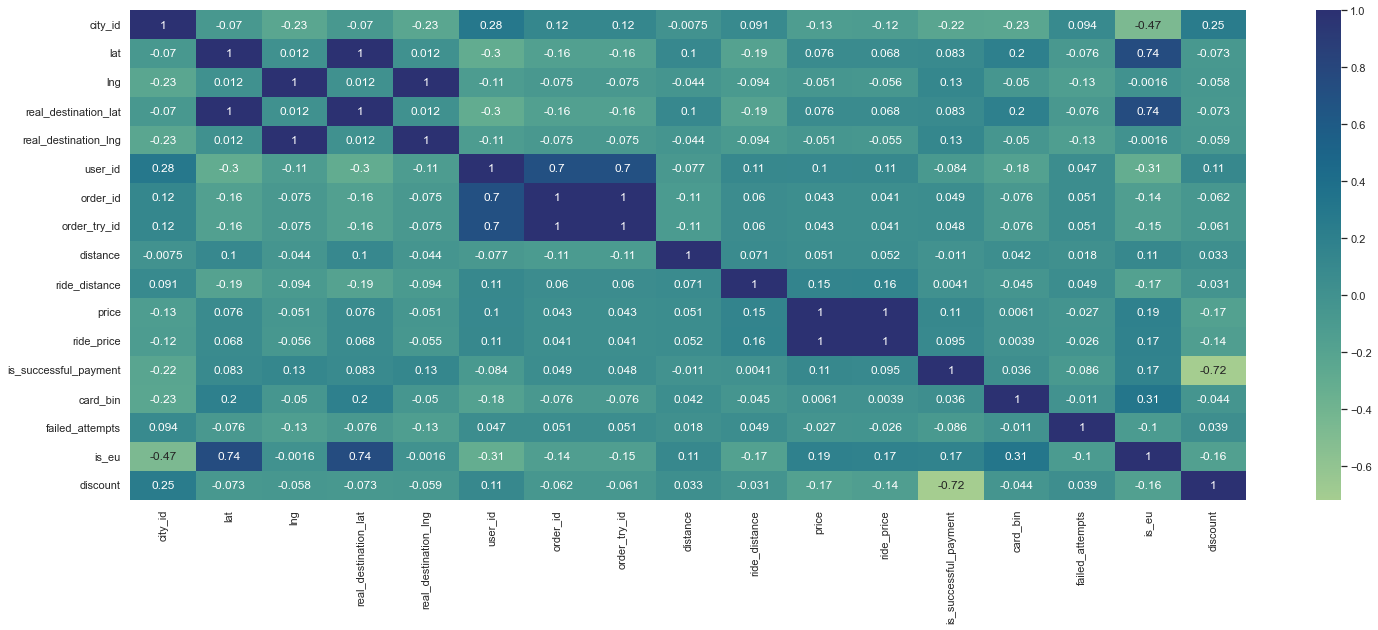

In [27]:
sns.heatmap(df.corr(),
            annot=True,
            cmap='crest'
            )

With the help of heatmap, I made two discoveries:
1. `discount` is negatively associated with payment success — higher discount lead to a lower success rate — exactly what we established in the previous section.
2. No other continuous variables are associated with `discount`, but it does not mean that the issue cannot be with categorical variables.

Within this hypothesis, my logic revolves around the fact that Bolt services are used mainly from mobile devices; hence, the GPS location and payments are made from the same devices. I would like to check what devices could explain the 100% discount.

In [28]:
table = pd.pivot_table(data=df[(df['discount'] == 1)],
                       values='is_successful_payment_str',
                       index=['device_name', 'device_os_version'],
                       columns='is_eu',
                       aggfunc='count')
table.sort_values(by=0, ascending=False).head(10)

,is_eu,0,1
device_name,device_os_version,,
iPhone6S,iOS10.3.2,877.0,816.0
iPhone6,iOS10.3.2,835.0,644.0
iPhone7,iOS10.3.2,659.0,640.0
iPhone5S,iOS10.3.2,531.0,562.0
iPhone6S,iOS10.3.3,443.0,324.0
samsungSM-G920F,samsung6.0.1,430.0,181.0
iPhone7,iOS10.3.3,429.0,286.0
iPhone6,iOS10.3.3,424.0,201.0
HUAWEIALE-L21,HUAWEI6.0,419.0,273.0


The Case is closed! iPhones are terrible devices, which affect the payment outcome both in EU and non-EU regions!

But if we check the overall distrubution of the devices despite the discount, iPhones are just popular phones, so, it is not the devices themselves, but rather something else.

In [29]:
table = pd.pivot_table(data=df,
                       values='is_successful_payment_str',
                       index=['device_name', 'device_os_version'],
                       columns='is_successful_payment',
                       aggfunc='count')
table.sort_values(by=0, ascending=False).head(20)

,is_successful_payment,0,1
device_name,device_os_version,,
iPhone6S,iOS10.3.2,2144.0,9536.0
iPhone6,iOS10.3.2,1948.0,8384.0
iPhone7,iOS10.3.2,1708.0,8404.0
iPhone5S,iOS10.3.2,1381.0,4668.0
samsungSM-G935F,samsung7.0,972.0,4408.0
iPhone6S,iOS10.3.3,956.0,4196.0
iPhoneSE,iOS10.3.2,910.0,4008.0
iPhone7,iOS10.3.3,887.0,4381.0
samsungSM-G930F,samsung7.0,852.0,3664.0


And this something else is once again geography and, to some extent, devices: the 100% discount is more frequently observed in South Africa, Latvia, Lithuania, and Romania. This fact is a nice refrain to the bar chart with the success rate for each country: not only was I able to deduce the research to EU/non-EU split, but I also pinpointed the main geographical weaknesses and potential problem (100% discount).

In [30]:
table = pd.pivot_table(data=df,
                       values='is_successful_payment_str',
                       index=['device_name', 'country_name', 'discount'],
                       columns='is_successful_payment',
                       aggfunc='count')
table.sort_values(by=0, ascending=False).head(20)

is_successful_payment                            0   1
device_name          country_name discount            
iPhone6              South Africa 1.0       1041.0 NaN
iPhone6S             South Africa 1.0        919.0 NaN
                     Latvia       1.0        843.0 NaN
iPhone5S             South Africa 1.0        767.0 NaN
iPhone6              Latvia       1.0        742.0 NaN
iPhone5S             Latvia       1.0        726.0 NaN
iPhone7              Latvia       1.0        639.0 NaN
                     South Africa 1.0        619.0 NaN
iPhone6S             Romania      1.0        477.0 NaN
HUAWEIALE-L21        South Africa 1.0        468.0 NaN
iPhone6              Romania      1.0        464.0 NaN
HUAWEIHUAWEI VNS-L31 South Africa 1.0        452.0 NaN
iPhoneSE             Latvia       1.0        446.0 NaN
iPhone7              Romania      1.0        431.0 NaN
iPhone6S             Lithuania    1.0        428.0 NaN
samsungSM-J500F      South Africa 1.0        427.0 NaN
iPhone6              Lithuania    1.0        392.0 NaN
iPhone5S             Lithuania    1.0        348.0 NaN
samsungSM-G920F      South Africa 1.0        332.0 NaN
iPhone7Plus          South Africa 1.0        330.0 NaN

In theory, the issue might be in the GPS connection (this variable was present in the Billing dataset, that is why I know that Bolt collected it). However, we see that European and African states are in the same risk group. That is why the issue seems more complicated, and I hope that Fraud team will teach me how to deal with it.

<br>

#### Hypothesis 5
_There is one factor, which is responsible for manual price review_

In [31]:
price_review = df_original[df_original['price_review_reason'].notnull()]
price_review.head()
price_review.price_review_reason.value_counts()

price_too_high                1005
calculation_failed              69
price_calculation_warnings      34
Name: price_review_reason, dtype: int64

In [32]:
table = pd.pivot_table(data=price_review,
                       values=['order_id'],
                       index=['price_review_reason', 'price', 'country'],
                       columns='is_successful_payment',
                       aggfunc=['count'])
table.sort_values(by=('count',      'order_id', 0), ascending=False).head(10)

count    
                                         order_id    
is_successful_payment                           0   1
price_review_reason        price country             
price_too_high             0.0   za         114.0 NaN
                                 ro          64.0 NaN
calculation_failed         0.0   za           8.0 NaN
price_too_high             0.0   mx           7.0 NaN
                                 ke           6.0 NaN
                                 rs           5.0 NaN
price_calculation_warnings 0.0   rs           5.0 NaN
price_too_high             0.0   ng           4.0 NaN
                                 lv           3.0 NaN
                           366.0 mx           3.0 NaN

The final hypothesis is just an excellent addition to the previous narrative: South Africa is an enormous market but also pretty unstable — the final pivot table illustrates that out of 1004 'price_too_high' complaints, 114 were made from South Africa, while the price was equal to 0 units.

<br>

#### Summary

Within the lengthy report, I tried to show that the Fraud team should pay more attention to particular geographical units at a particular time and, what is more important, explore the causality between failed payment and `discount` being 100%. Moreover, I tried to introduce the instruments which could be automated and used for the overall assessment on a global scale.

From my side, in terms of developments, I would say the following:
1. Emphasize should be made on countries with prevailing cash payment;
2. Machine learning could be applied to classify the payment as 'successful' or 'failed' based on the presented features. I had my doubts if I should include it or not, but since I did not have any educated assumptions about the causalities, I decided not to deliver raw models.
3. As I mentioned in the beginning, the major assumption was that failed payments were not failed for technical reasons but because of the fraudulent behavior of the rider. As a result, I have narrowed down the areas where more nuances fraud detecting mechanisms should be used.

Thanks a lot for a fun task!